# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Imad Eddine **MAROUF**

**Author:** Mert **ERTUGRUL**

**Author:** Arnaud **DUVIEUSART**

**Due date:** 26.03.2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

/Users/user/miniconda3/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


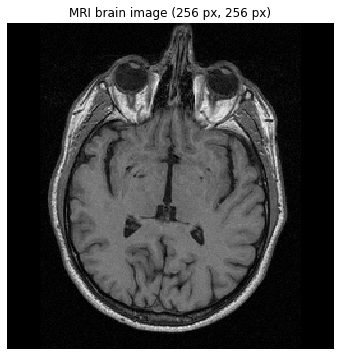

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import cv2

import numpy as np
import pandas as pd

import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
import skimage.measure
import skimage.color
from skimage import exposure

%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [4]:
#VISUALISATION FUNCTIONS
def display_brain_img(array):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(array, cmap='gray')
    ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
    ax.axis('off')
    plt.show()

def display_hist(array):
    nb_bins = 256

    # Display histogram
    plt.figure(figsize=(12, 7))
    plt.hist(array.ravel(), bins=nb_bins)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256 bins histogram')

    plt.show()
    
def binarize(elem, threshold = 0.5):
    if elem<threshold:
        return 0
    else:
        return 1
    
binarize_vec = np.vectorize(binarize)

### 1.2 Region growing
- This approach to segmentation examines neighboring pixels of initial “seed points” and determines whether the pixel neighbors should be added to the region. The process is iterated on, in the same manner as general data clustering algorithms"
- region growing is an iterative method used to extract similar parts of an image. One or several points are chosen as a start. The region then grows until it is finally blocked by the stop criteria.
- The chosen criteria is in this case a difference between outside pixel's intensity value and the region's mean. The pixel with minimum intensity in the region neighbouhood is chosen to be included. The growing stops as soon as the difference is larger than a threshold.


Text(0, 0.5, 'Number of pixels')

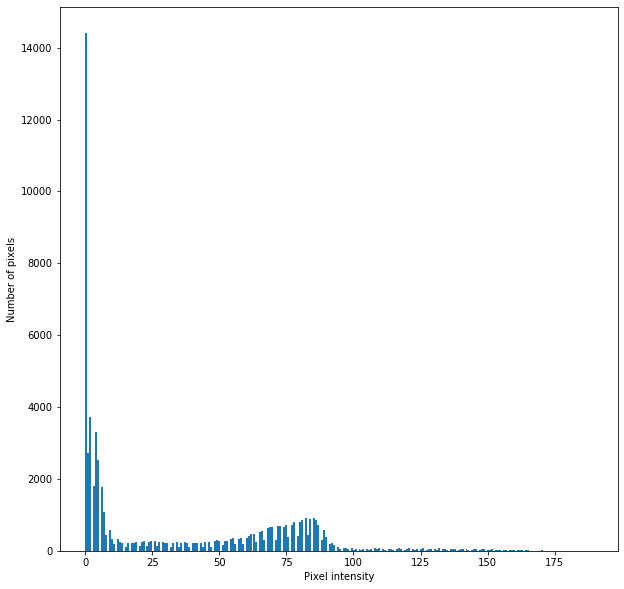

In [5]:
plt.figure(figsize=(10, 10))
plt.hist(brain_im.ravel(), bins = 256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')

- We see that most cells intesity is between 55 and 90

In order to implement the region growing method, we need to define a criteria. We would like to use threshold as our criteria for growing regions within the image.

SKimage library does provide many built-in functions to get the Threshold for the image, We illustrate some of them down below to see the result of each filter

In [8]:
# Different methods to calculate Threshold
from skimage.filters import *

threshold_functions= [threshold_otsu, threshold_yen, threshold_isodata, threshold_li, threshold_minimum, threshold_mean, threshold_triangle]
threshold_labels=['Otsu', 'Yen','Isodata', 'Li', 'Minimum', 'Mean', 'Triangle']

thresholds =pd.DataFrame(index=threshold_labels, columns={'Value'})

,Value
Otsu,42
Yen,94
Isodata,42
Li,22.2702
Minimum,36
Mean,35.1625
Triangle,11


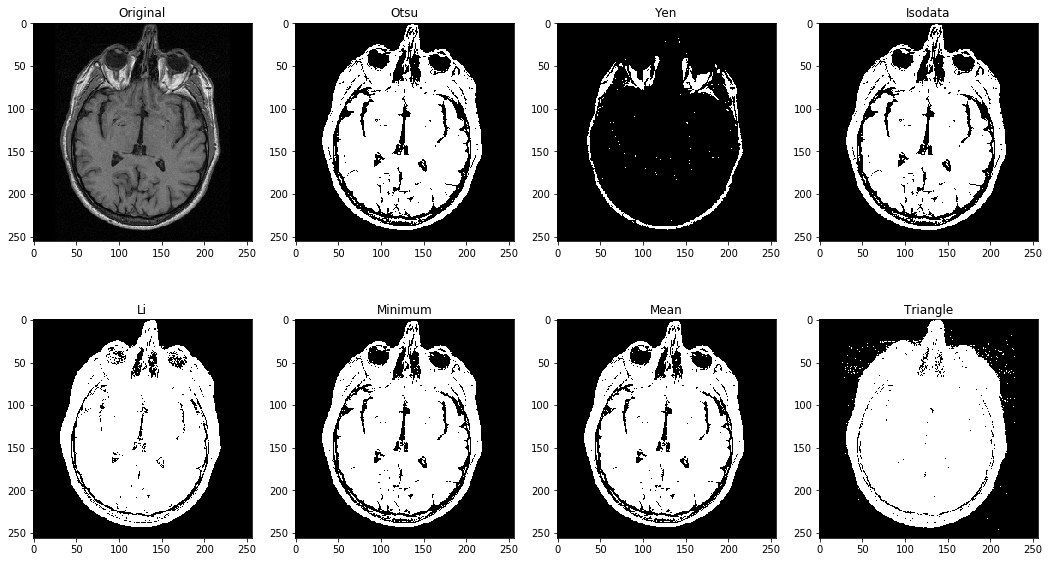

In [9]:
plt.figure(figsize=(18,10))
plt.subplot(2,4,1)
plt.imshow(brain_im, cmap='gray')
plt.title('Original')

for i, fct in enumerate(threshold_functions):
    threshold_tmp=fct(brain_im)
    thresholds.iloc[i,0]=threshold_tmp
    
    plt.subplot(2,4,i+2)
    plt.imshow(brain_im > threshold_tmp, cmap='gray')
    plt.title(threshold_labels[i])
    
display(thresholds)

In [10]:
def region_growing(img, seeds, threshold): #seeds is an array of tuples (coordinates)
    " homogeneity criterion  : Absolute intensity differences are used for region growing definition"
    
    #Getting size, width, height of input
    height, width = img.shape[0], img.shape[1]
    #print("height: ", height," width: ", width)
    size = height * width
    
    
    
    #Seed starting value
    pixels_in_region = [seeds[0]]
    #print(seeds[0])
    seed_intensities = img[seeds[0]]
    
    
    neighbors = [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
    growing_region_size = 1

    #Initialize our segmented output to zero
    segmented = np.zeros((height, width), dtype=np.uint8)
    checked_pixels = []
    segmentation_candidates = []
    below_treshold = True
    for seed in seeds:
        for i in range(len(neighbors)):
            coordinates = (seed[0] + neighbors[i][0],seed[1] + neighbors[i][1])
            if coordinates not in pixels_in_region:
                segmentation_candidates.append(coordinates)

        #Region will start growing until the intensity difference reaches the threshold
        while (below_treshold and growing_region_size < 15000):
            differences_of_intensities = []
            to_add_to_region_index = []
            to_add_to_region = []

            #differences_of_intensities : differences between mean intensity of region and all candidates to the region 
            differences_of_intensities = [abs(np.mean(seed_intensities)-img[coord]) for coord in segmentation_candidates]
            #to_add_to_region_index : index of pixels satisfying homogeneity criterion
            to_add_to_region_index = [i for i in range(len(differences_of_intensities)) if differences_of_intensities[i] < threshold]
            to_add_to_region = [segmentation_candidates[i] for i in to_add_to_region_index]
            #to_add_to_region = segmentation_candidates[min(enumerate(differences_of_intensities), key=itemgetter(1))[0]]
            if(len(to_add_to_region) == 0):
                below_treshold = False
            else:
                for pixel in to_add_to_region:
                    pixels_in_region.append(pixel)
                    segmentation_candidates.remove(pixel)
                    segmented[pixel] = 255
                    growing_region_size += 1
                    for i in range(len(neighbors)):
                        coordinates = (pixel[0] + neighbors[i][0],pixel[1] + neighbors[i][1])
                        if coordinates not in pixels_in_region:
                            segmentation_candidates.append(coordinates)
                            segmentation_candidates = list(set(segmentation_candidates))
            
    return segmented, growing_region_size

In [11]:
segmented_img, region_size = region_growing(brain_im, [(184,104)], 17)

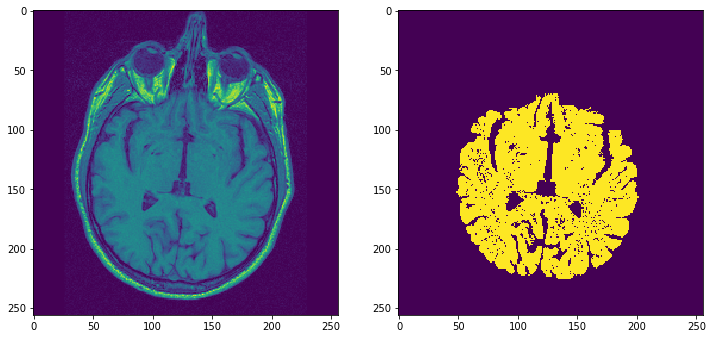

In [12]:
_, axarr = plt.subplots(1, 2, figsize=(12, 7))
axarr[0].imshow(brain_im)
axarr[1].imshow(segmented_img)
plt.show()

---------------------------------------------------------------------------------------------------

- Using Built-in functions in OpenCV library for segmentation using region-growing

**Documentation:** https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=floodfill

In [13]:
seed=(100,100)
mask = np.zeros((brain_im.shape[0]+2, brain_im.shape[1]+2), np.uint8)
region_growing_im = cv2.floodFill(brain_im.copy(), mask, seedPoint=seed, newVal=(255,0,0), loDiff=(7), upDiff=(8))

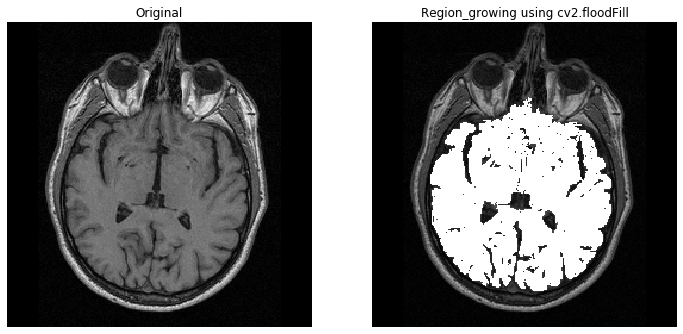

In [14]:
_, axarr = plt.subplots(1, 2, figsize=(12, 7))

axarr[0].imshow(brain_im, cmap='gray')
axarr[0].set_title('Original')
axarr[0].axis('off')

axarr[1].imshow(region_growing_im[1], cmap='gray')
axarr[1].set_title('Region_growing using cv2.floodFill')
axarr[1].axis('off')

plt.show()

----------------------------------------------------------------------------------------------------------------------

### 1.3 Contour detection
We can define contours as the sharp difference in intesity in an image, in this lab we will try to implement contour detection using:

 - Operators like: * Robert operator    * Prewitt     * Sobel
 - Zero-crossing of the second derivative
 - Mathematical Morphologies
 
SKImage library provides all of these methods:

**Documentation:** 

Filters: https://scikit-image.org/docs/dev/api/skimage.filters.html

Find contour: https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html

In [6]:
#Applying Operators
import skimage.filters

brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True)

Robert = skimage.filters.roberts(brain_im)
Sobel = skimage.filters.sobel(brain_im)
Scharr = skimage.filters.scharr(brain_im)
Prewitt = skimage.filters.prewitt(brain_im)

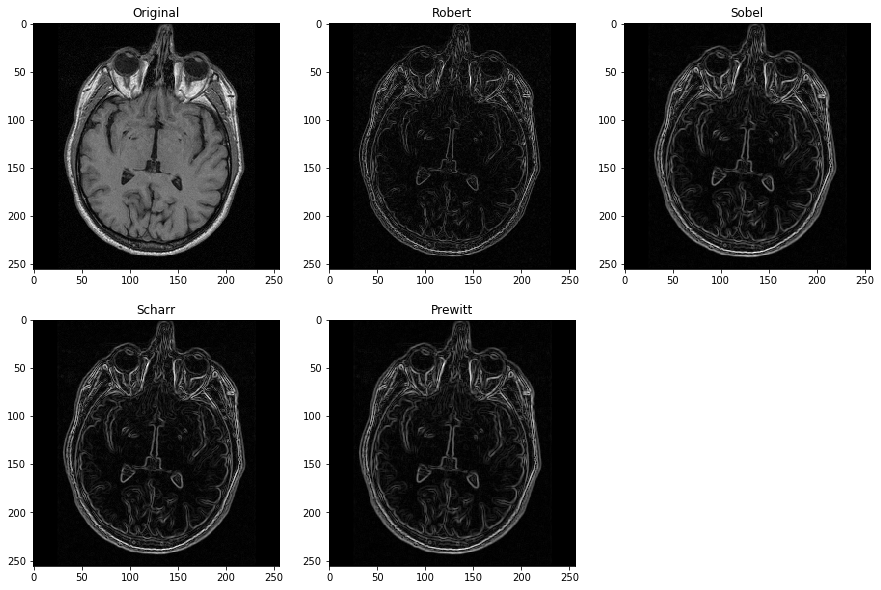

In [7]:
# Showing Images
filters = [Robert, Sobel, Scharr, Prewitt]
filters_str = ['Robert', 'Sobel', 'Scharr', 'Prewitt']

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.imshow(brain_im, cmap='gray')
plt.title('Original')

for i in range(len(filters)):
    plt.subplot(2, 3, i+2)
    plt.imshow(filters[i], cmap='gray')   
    plt.title(filters_str[i])

In [8]:
import skimage.measure
from skimage import filters
from skimage import feature, exposure
from skimage.feature import blob_log

#contours = skimage.measure.find_contours(brain_im, 0.5)
#print(brain_im.shape)
#type(contours)

img_brain = cv2.imread(os.path.join(data_path, 'brain-slice40.tiff'))
imgray = cv2.cvtColor(img_brain,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 80, 200,0)

#cv2.findContours() function, first one is source image, 
#second is contour retrieval mode, third is contour approximation method. 
#And it outputs the image, contours and hierarchy. contours is a Python list of all the contours in the image. 
#Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

#Draw contour
img_contours = cv2.drawContours(np.ones_like(img_brain), contours, -1, (0, 0, 255), 1)

(-0.5, 255.5, 255.5, -0.5)

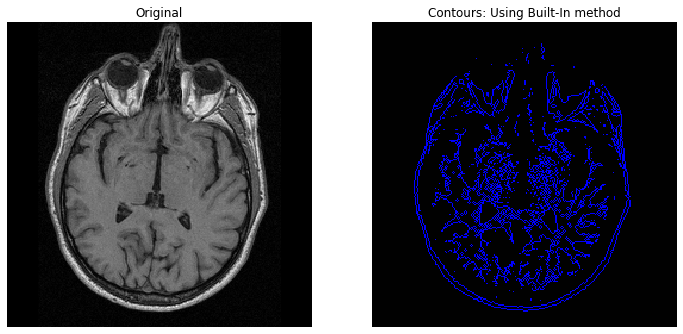

In [9]:
_, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')


ax[1].imshow(img_contours, cmap='gray')
ax[1].set_title('Contours: Using Built-In method')
ax[1].axis('off')


#### Binary Region Growing

Since the previous region growing implementation worked with varying pixel intensities, a new, modified version is necessary for dealing with with region growing within a binarized contour image. 
Region growing is carried out within the countours surrounding the seeds.


In [21]:
#Binary region growing

def region_growing_binary(img, seeds): #seeds is an array of tuples (coordinates)
    " homogeneity criterion  : Absolute intensity differences are used for region growing definition"
    
    #Getting size, width, height of input
    height, width = img.shape[0], img.shape[1]
    #print("height: ", height," width: ", width)
    size = height * width
    
    
    
    #Seed starting value
    pixels_in_region = [seeds[0]]
    #print(seeds[0])
    seed_intensities = img[seeds[0]]
    
    
    neighbors = [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
    growing_region_size = 1

    #Initialize our segmented output to zero
    segmented = np.zeros((height, width), dtype=np.uint8)
    checked_pixels = []
    segmentation_candidates = []
    
    for seed in seeds:
        below_treshold = True
        for i in range(len(neighbors)):
            coordinates = (seed[0] + neighbors[i][0],seed[1] + neighbors[i][1])
            if coordinates not in pixels_in_region:
                segmentation_candidates.append(coordinates)

        #Region will start growing until the intensity difference reaches the threshold
        while (below_treshold and growing_region_size < 15000):

            to_add_to_region = [coord for coord in segmentation_candidates if img[coord] == 0]
            if(len(to_add_to_region) == 0):
                below_treshold = False
            else:
                for pixel in to_add_to_region:
                    pixels_in_region.append(pixel)
                    segmentation_candidates.remove(pixel)
                    segmented[pixel] = 255
                    growing_region_size += 1
                    for i in range(len(neighbors)):
                        coordinates = (pixel[0] + neighbors[i][0],pixel[1] + neighbors[i][1])
                        if coordinates not in pixels_in_region:
                            segmentation_candidates.append(coordinates)
                            segmentation_candidates = list(set(segmentation_candidates))
    
    return segmented, growing_region_size

The sobel filter is applied for contour detection. Region growing is applied to the binarized version of the contour image.

In [22]:
sobel_img = filters.sobel(brain_im)
segmented, region_size = region_growing_binary(binarize_vec(sobel_img, 0.0437), [(150,150)])

(-0.5, 255.5, 255.5, -0.5)

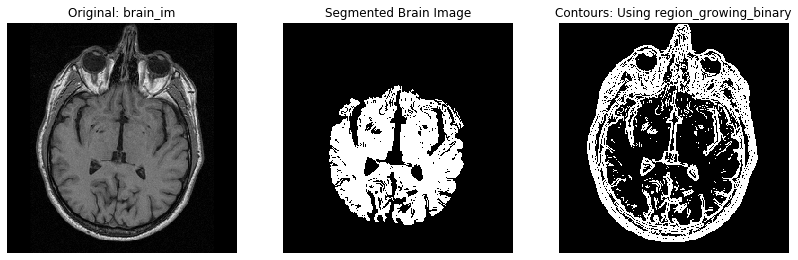

In [23]:
_, ax = plt.subplots(1, 3, figsize=(14, 10))

ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original: brain_im')
ax[0].axis('off')

ax[1].imshow(segmented, cmap='gray')
ax[1].set_title('Segmented Brain Image')
ax[1].axis('off')

ax[2].imshow(binarize_vec(sobel_img, 0.0437), cmap='gray')
ax[2].set_title('Contours: Using region_growing_binary')
ax[2].axis('off')

------------------------------------------------------------------------------------------------------------
**Calculating the size of a brain:**


*1\ By Using region_growing function defined above:*

In [24]:
print("\tSize of brain: %d pixels" %region_size)

	Size of brain: 13709 pixels


*2\ Using cv2.fillFlood():*

In [25]:
brainImage = region_growing_im[1]
print("\tShape of Brain Image using cv2.fillFlood(): ", brainImage.shape)

	Shape of Brain Image using cv2.fillFlood():  (256, 256)


In [26]:
pixels = 0
for x in range(256):
    for y in range(256):
        if brainImage[x, y] == 255:
            pixels +=1

In [27]:
print("\tNumber of pixels using cv2.fillFlood(): %d pixels" % pixels)

	Number of pixels using cv2.fillFlood(): 16379 pixels


*3\ Using Contours:*

We subtract the contour we calculated above from the orignal image (element-wise), then calculate the number of pixels where the intensity of the pixel is equal to zero (means only the tissue of the brain which remains).

In [28]:
img_defined = binarize_vec(sobel_img, 0.0437)

In [29]:
print("\tOriginal brain image shape: ", brain_im.shape)
print("\tContour shape: ", img_defined.shape)

	Original brain image shape:  (256, 256)
	Contour shape:  (256, 256)


In [30]:
output = np.subtract(brain_im, img_defined)

In [31]:
pixels = 0
for x in range(256):
    for y in range(256):
        if output[x, y] < 0:
            output[x, y] == 0
        if output[x, y] == 0:
            pixels +=1

In [32]:
print("\tNumber of pixels using contours: %d pixels" % pixels)

	Number of pixels using contours: 14427 pixels


**Comment:**

- We can see that the area of the brain image in pixels using  out defined method of region growing, and the fillFlood() method defined in OpenCV library have approximately the same results.

- The reason why area using fillFlood() is bigger than the other methods is that as illustrated in the figures above, we can see that certain regions whithin the tissue of the brain are filled altough in the original brain image are not part of the tissue of the brain.

- I think the area calculated by using the contour method is most precise because it takes into consideration the inner regions of the brain as they are not part of the tissue.

### 1.4 Additional method(s)

### 1.4.1 Region Splitting

Region splitting is a segmentation method where a given region/image is split into subregions recursively until all subregions satisfy a certain homogeneity criteria.

This implementation does not include the merging of collectively homogeneous subregions into larger regions. Therefore, it can be though of as an intermediate step towards a complete Split and Merge implementation, which is given in 1.4.2

The mean, variance, maximum and minimum pixel values present in a representative brain tissue area are used to form criteria for:
* whether a region might include a fraction of brain tissue
* whether a region consists solely of brain tissue

Only the images that potentially include brain tissue are subjected to homogeneity criteria, other regions such as pure background areas do not participate in splitting.
The algorithm is explained after the following part.

#### Inspecting the Properties of the Brain Tissue

A representative section of the brain tissue is selected from the image. Its pixel value distribution is given together with a close up view of the brain as well as the whole image. 

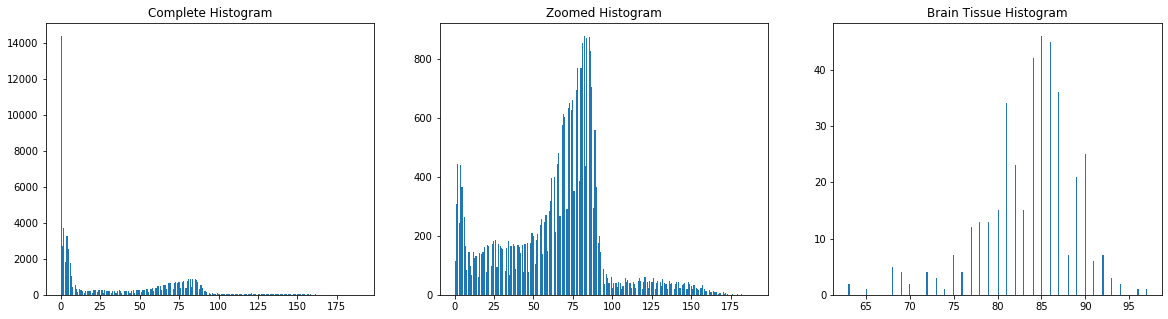

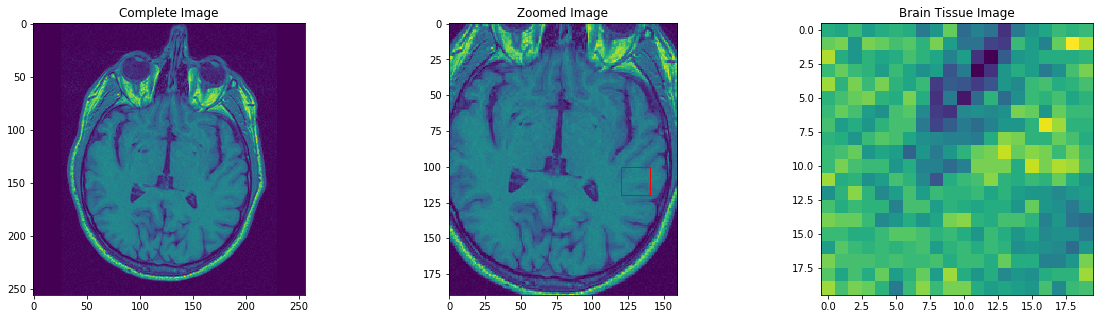

In [33]:
import matplotlib.patches as pat

zoomed_im = brain_im[50:240,50:210]
hom_im = zoomed_im[100:120,110:130]

rect = pat.Rectangle((120,100),20,20, edgecolor='r', facecolor="none")


_, axarr2 = plt.subplots(1, 3,figsize=(20, 5))
_, axarr3 = plt.subplots(1, 3,figsize=(20, 5))

axarr2[0].hist(brain_im.ravel(), bins = 256)
axarr2[0].set_title("Complete Histogram")
axarr2[1].hist(zoomed_im.ravel(), bins = 256)
axarr2[1].set_title("Zoomed Histogram")
axarr2[2].hist(hom_im.ravel(), bins = 256)
axarr2[2].set_title("Brain Tissue Histogram")

axarr3[0].imshow(brain_im)
axarr3[0].set_title("Complete Image")
axarr3[1].imshow(zoomed_im)
axarr3[1].set_title("Zoomed Image")
axarr3[1].add_patch(rect)
axarr3[2].imshow(hom_im)
axarr3[2].set_title("Brain Tissue Image")
plt.show()

#### The Algorithm 
* The minimum and maximum pixel values present in the close up image are used to determine whether a subregion includes any brain tissue. If no pixel is within the range of these values, the subregion is discarded and not used for splitting further.
* If a subregion is found to include brain tissue, 
    * If the region meats the homogeneity criteria, it is not split further
    * The regions that are collectively homogeneous are merged
    * Non-homogeneous regions are split again
* If no subregions are left for further splitting, the process is complete

The properties of the representative brain tissue image are obtained below:

In [50]:
#obtaining properties of the tissue image for threshold selection
mean = np.mean(hom_im).round()
var = np.var(hom_im).round()
min_val = np.amin(hom_im)
max_val = np.amax(hom_im)
margin = max( abs(mean-max_val), abs(mean-min_val) ) 
#variance margin is selected arbitrarily
variance_margin = 40

print( "\tMinimum Pixel Value:" + str(min_val))
print( "\tMaximum Pixel Value:" + str(max_val))

print( "\tVariance of Tissue Image:" + str(var ))
print( "\tMean of Tissue Image:" + str(mean))
print( "\tRange of Pixel Values Present:" + str(margin ))

	Minimum Pixel Value:63
	Maximum Pixel Value:97
	Variance of Tissue Image:28.0
	Mean of Tissue Image:84.0
	Range of Pixel Values Present:21.0



The method **region_splitting** works recursively.

Arguments:
* **region_list**: current list of regions that were formed by a previous splitting operation
* **rate**: how many parts each vertice of an image will be split into. Splitting into 4 images means rate=2
* **count**: current number of pixels that satisfy the brain tissue criteria
* **split_segmented**: array that highlights the pixels classified as brain tissue 

Outputs: these are fed back to the previous call of region_splitting, unless it is the last iteration. In that case, they are the final results.
* count
* split_segmented

In [51]:
def region_splitting(region_list, rate, count, split_segmented):
    
    #checking for regions to segment
    if len(region_list) == 0:
        return count, split_segmented
    
    #list for regions to be split in the next iteration
    new_reg_list = []
    
    for regTuple in region_list:
        h1,w1,h2,w2 = regTuple[0],regTuple[1],regTuple[2],regTuple[3]
        reg = brain_im[h1:h2, w1:w2]
        #checking if any pixels within brain_tissue brightness range are present 
        if ( min_val <= np.amax(reg)) and ( max_val >= np.amin(reg) ) : 
            if abs( mean - np.mean(reg) ) <= margin and abs( var - np.var(reg) ) <= variance_margin:
            
                #region is within the brain tissue
                #regions.append(regTuple)
                count += reg.size
                split_segmented[h1:h2, w1:w2] = 255
                
            elif (h2-h1)/rate >= rate and (h2-h1)/rate >= rate :
                #region contains other elements as well as brain tissue
                #region will be split
                for h in range(rate):
                    for w in range(rate):
                        new_reg_list.append( ( h1 + h*(h2-h1)//rate 
                                             , w1 + w*(w2-w1)//rate 
                                             , h1 + (h+1)*(h2-h1)//rate
                                             , w1 + (w+1)*(w2-w1)//rate ) )
            else:
                new_reg_list.append( ( h1 , w1 , h1 + 1, w1 + 1 ))
       
    count, split_segmented = region_splitting(new_reg_list, rate, count, split_segmented)
    
    return count, split_segmented
    

In [52]:
split_rate = 2
regions = []

#number of pixels within target area
count = 0

height, width = brain_im.shape[0], brain_im.shape[1]

#empty canvas to be filled with identified brain tissue regions
unsegmented = np.zeros((height, width), dtype=np.uint8)

px_count, result = region_splitting( [(0, 0, height, width) ], split_rate, count, unsegmented )
print('\tNumber of pixels within brain tissue: ' + str(px_count))

	Number of pixels within brain tissue: 16435


**Comment:**

- Since this implementation does not include merging, non-brain tussue regions are wrongly classified all throughout the image. This algorithm is bound to misclasify areas of the image that have similar visual properties to brain-tissue that are disconnected from the brain. We aim to solve this issue in 1.4.2: Split and Merge.

- The number of pixels outputted here includes a large amount of misclasified pixels. The non-connected misclassifeid areas will now be eliminated through a series of morphological operations and the number will change.
--------------------------------------------------------------------------------------------------
The following morphological operations are aimed at increasing the quality and accuracy of the result. 

In [68]:
from skimage import morphology
final = morphology.diameter_opening(result, diameter_threshold=30, connectivity=2, parent=None, tree_traverser=None)
final = morphology.dilation(final, selem=None, out=None, shift_x=False, shift_y=False)

**diameter_opening**: Applied to get rid of the non-connected external regions that have properties similar to brain tissue.  
                   any region that does not extend as far as the diameter threshold in any direction is eliminated. 
                   
**dilation**: The alogirthm produces an image that appears eroded by default since the resolution of the segmentation is not high enough to fully capture curvatures and the thresholds are too high t capture certain details. Dilation undoes this effect, but also causes some folds and cavities to shrink in size or be lost.

Text(0.5, 1.0, 'Result After Morphological Operations')

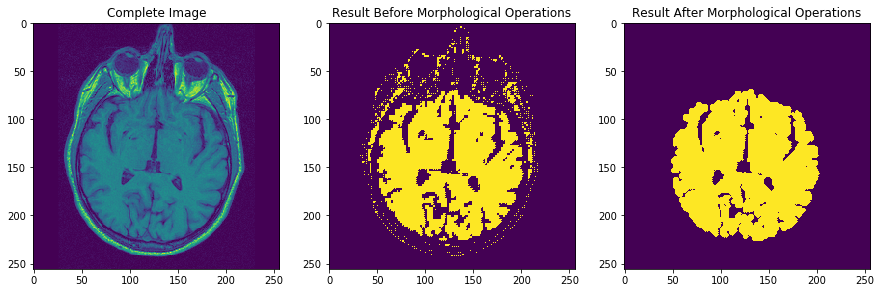

In [69]:
_, axarr = plt.subplots(1, 3,figsize=(15, 10))
axarr[0].imshow(brain_im)
axarr[0].set_title("Complete Image")
axarr[1].imshow(result)
axarr[1].set_title("Result Before Morphological Operations")
axarr[2].imshow(final)
axarr[2].set_title("Result After Morphological Operations") 

The number of pixels in the brain tissue before and after morphological operations:

In [73]:
pixels = 0
for x in range(height):
    for y in range(width):
        if final[x, y] == 255:
            pixels +=1
print('Before morphological ops: ' + str(px_count))
print('After morphological ops: ' + str(pixels))

Before morphological ops: 16435
After morphological ops: 16799


While removing misclassified areas decreases the pixel count, dilation caluses a greater increase. 

Hence the final count is higher and similar to the result of 1.3


### 1.4.2 Region Splitting and Merging

- Unlike in the prervios splitting implementation,in this implementation the maximum and minimum pixel values of the brain tissue as well as the mean value will be assumed as unknown, and every region will be inspected solely based on homogeneity. The homogeneity criteria remains the same, a variance threshold will be applied.

- Every homogeneous region will be compared to neighbouring homogeneous regions, and if their combination also satisfies homogeneity, they will be merged. The combined homogeneity of two regions is tested differently. The difference between the means of the two regions is also compared to a threshold and the combined varience of the regions is compared to a variance threshold.

- The thresholds are dynmaic, meaning that as splitting and merging continues and the number of regions goes up or down, variance and mean difference thresholds are updated to speed up the process.

- Among the last remaining regions, the appropriate region will be selected as the brain tissue based on a criteria.

#### Region Class
In order to simplify the implementation, a class that holds the properties of a region and carries out operations required by splitting and merging is implemented.
* The region is initialized by a single subregion, which is itself. 
* If another region is merged to it, that region as added as a subregion.
* If it is split, it is discarded, producing new regions to be operated on.

In [647]:
class Region:
    
    '''
    locTuple: contains the indexes for the upper-left and lower-right corners of the region
    index: - used to locate the region in the dictionary of regions
           - the corresponding area on the picture of regions is filled or "painted" with this value
    source: the original image which this object represents a region of
    hs, ws, hf, wf: coordinate references for ease of use 
    
    '''    
    def __init__(self, locTuple, index, source ): 
        self.subregions =[locTuple]
        self.index = index
        self.locTuple =locTuple
        self.source = source       
        self.hs,self.ws,self.hf,self.wf = locTuple[0],locTuple[1],locTuple[2],locTuple[3]
        
        #obtaining the mean and variance from the corresponding region on the source image
        self.mean = np.mean(source[self.hs:self.hf, self.ws:self.wf])
        self.var = np.var(source[self.hs:self.hf, self.ws:self.wf])
        self.size = (self.hf-self.hs)*(self.wf-self.ws)
        
    #splits the region into rate-squared subregions
    def split(self, glob_index, rate, canvas):
        #list of resulting images
        new_regions = {}
        
        #to increase speed, resolution is decreased so splitting will end before the last possible split
        if self.size >= rate**3:
              for h in range(rate):
                for w in range(rate):
                    new_reg = Region( ( self.hs + h*(self.hf-self.hs)//rate 
                                                               , self.ws + w*(self.wf-self.ws)//rate 
                                                               , self.hs + (h+1)*(self.hf-self.hs)//rate 
                                                               , self.ws + (w+1)*(self.wf-self.ws)//rate ), glob_index, self.source )
                    new_regions.update({glob_index : new_reg } )
                    #the corresponding region in the matrix or "canvas" of regions is filled with a new value 
                    canvas[new_reg.locTuple[0]:new_reg.locTuple[2],new_reg.locTuple[1]:new_reg.locTuple[3]] = glob_index
                    glob_index += 1
            
        return glob_index, new_regions, canvas
        
    #adds a new subregion, statistical parameters are provided from outside for ease of use in region_split_merge
    def merge_with(self, newRegion,  new_mean, new_var, new_size):
        
            self.size = new_size
            self.mean = new_mean
            self.var = new_var
            self.subregions.extend(newRegion.subregions)
            return self
        
    #returns a numpy array the size of the source image with the region highlighted 
    def get_visual(self):
            new_canvas = np.zeros((height, width), dtype=np.uint8)
            for reg in self.subregions:
                new_canvas[reg[0]:reg[2],reg[1]:reg[3]] = 255
            return new_canvas
        
    #to make Region a sortable class (based on region size):
        
    def __lt__(self, other):
        return self.size < other.size
    
    def __le__(self, other):
        return self.size <= other.size

    def __gt__(self, other):
        return self.size> other.size

    def __ge__(self, other):
        return self.size >= other.size

    def __eq__(self, other):
        return self.size == other.size

    def __ne__(self, other):
        return self.size != other.size
            

#### Region Split and Merge 
- **region_dict** : The current regions are kept within a dictionary. The choice to use a dictionary instead of a list as in 1.4.1 came from the fact that a neighbor region detection method was needed. The area occupied by each region is filled by their key value in the index. A region can look at the surrounding tiles and find the region object based on the value of the tile.

- **rate**: how many parts each vertice of an image will be split into. Splitting into 4 images means rate=2

- **canvas**: the array of regions filled with each region's index/dictionary key

- **glob_index**: the next index/dicitonary key to be assigned to newly formed regions 

- **varCrit,meanCrit** : variance and mean thresholds

In [648]:
def region_split_merge(region_dict, rate, canvas, glob_index, varCrit, meanCrit):
    
    #Splitting
    
    split_temp_keys = list(region_dict.keys())
    for key in split_temp_keys:
        
           #regions that do not satisfy the homogeneity condition are split
            if abs( var - region_dict[key].var ) > variance_margin:  
                
                glob_index, new_regs, canvas= region_dict.pop(key).split(glob_index, rate, canvas )
                region_dict.update(new_regs)
        
    oldRegNum = len(region_dict)
    merge_temp_keys = list(region_dict.keys())
    
    #Merging
    
    for key1 in merge_temp_keys:
        #to avoid iterating over deleted keys 
        if key1 in region_dict:
            reg1 = region_dict[key1]
            #the array entries neighbouring each subregion of the region are identified
            for subreg in reg1.subregions:
                
                neighbours = canvas[max(0,subreg[0]-2):min(height,subreg[2]+2),max(0,subreg[1]-2):min(width,subreg[3]+2)]
                neighbours = set(neighbours.flatten())
                neighbours.discard(key1)
               
                if len(neighbours):   
                    for key2 in neighbours:
                        reg2 = region_dict.get(key2) 
                        #to avoid errors down the line
                        if reg2 is not None:
                            #computing hypothetical values of a new merged region
                            new_size =reg1.size + reg2.size
                            new_mean = (reg1.mean*reg1.size + reg2.mean*reg2.size)/new_size
                            new_var = (reg1.size*(reg1.var + reg1.mean**2) + reg2.size*(reg2.mean**2 + reg2.var))/new_size - new_mean**2
                            #merging regions if homogeneity criteria between the regions is met
                            if  new_var < varCrit and abs(reg1.mean-reg2.mean) < meanCrit : 
                
                                for subreg2 in reg2.subregions:
                                    canvas[subreg2[0]:subreg2[2],subreg2[1]:subreg2[3]] = key1 

                                region_dict[key1] = reg1.merge_with( region_dict.pop(key2), new_mean, new_var, new_size)

    #checking if splitting and merging have occured during the last iteration
    if  len(region_dict) != oldRegNum or  len(region_dict) != len(split_temp_keys):
        #to facilitate merging
        if len(region_dict)> 1000:
            varCrit += 0.5
            meanCrit += 0.6

        region_split_merge(region_dict, rate, canvas, glob_index, varCrit, meanCrit)
    #this is an arbitrary condition to loosen homogeneity contraints when too many regions are left after merging 
    #to encourage further merging into larger regions
    elif len(region_dict)> 400:
        varCrit += 0.3
        meanCrit += 0.3
        region_split_merge(region_dict, rate, canvas, glob_index, varCrit, meanCrit)
        
    return region_dict, canvas

In [649]:
varCrit = 30
meanCrit = 30
canvas = np.zeros((height, width), dtype=np.uint16)
rootRegion = Region( (0, 0, height, width), 0, brain_im)
regionsLeft,canvas = region_split_merge( {0:rootRegion}, split_rate, canvas, 1, varCrit, meanCrit )

 Due to the structure of its implementation, merging cannot continue after approximately 300 regions are left. 

At this point in the merging process, the prominent regions in the image are already segmented, the largest region being the background and the following regions being large brain tissue regions that could not be merged due to defficiencies of the implementation. 

The implementation of checking for neighbouring regions stops giving sufficient results after a large number of iterations as each region now consists of a large number of subregions in itself and checking for each one becomes error prone.
Therefore the merging process is stopped early in this implementation.

- In order to obtain the brain tissue subregions and merge them seperately, the mean and variance values of the largest remaining regions are compared without checking if they are neighbors. 
- The regions that have similar mena and variance to the 2nd largest region (brain) are combined with it to obtain the final result.

In [650]:
sortedList = sorted(regionsLeft.values(), reverse=True)

#the number of largest regions to be inspected is selected arbitrarily here,
#but it can alterantively be selected based on a size threshold.
#the comparison reference is selected as the 2nd largest region, which would be the largest brain tissue region
#the largest region on the other hand would be the background
largest_regs = sortedList[2:8]
largest_tissue =sortedList[1]
brain_pix = largest_tissue.size

#the complete brain tissue image is formed on new_canvas
new_canvas = largest_tissue.get_visual()

for region in largest_regs:
    if abs(region.var-largest_tissue.var) < varCrit and abs(region.mean-largest_tissue.mean) < meanCrit:   
        brain_pix += region.size
        new_canvas += region.get_visual()

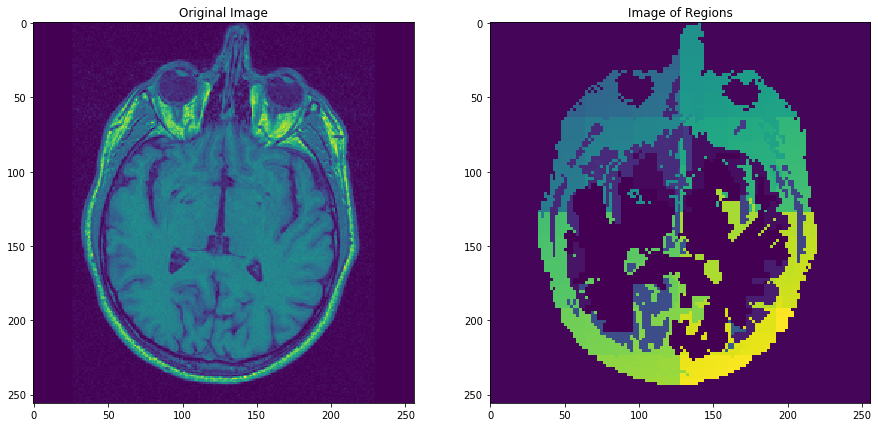

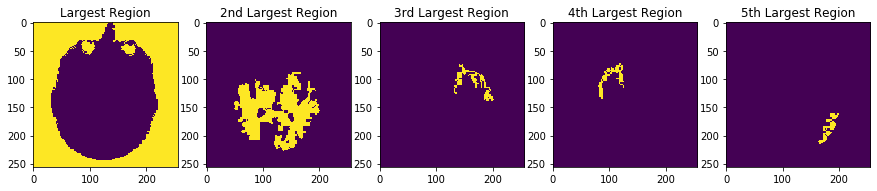

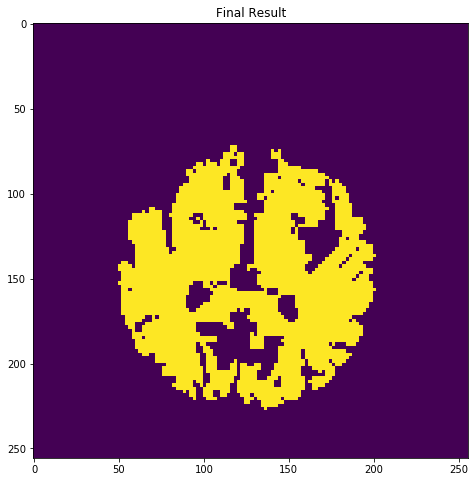

In [652]:
#plotting results

_, axarr = plt.subplots(1, 2,figsize=(15, 10))
axarr[0].imshow(brain_im)
axarr[0].set_title("Original Image")
axarr[1].imshow(canvas)
axarr[1].set_title("Image of Regions")

_, axarr2 = plt.subplots(1, 5,figsize=(15, 10))

axarr2[0].imshow(sortedList[0].get_visual())
axarr2[0].set_title("Largest Region")
axarr2[1].imshow(sortedList[1].get_visual())
axarr2[1].set_title("2nd Largest Region")
axarr2[2].imshow(sortedList[2].get_visual())
axarr2[2].set_title("3rd Largest Region")
axarr2[3].imshow(sortedList[3].get_visual())
axarr2[3].set_title("4th Largest Region")
axarr2[4].imshow(sortedList[4].get_visual())
axarr2[4].set_title("5th Largest Region")

_, axarr3 = plt.subplots(1, 1,figsize=(10, 8))
axarr3.set_title("Final Result")
axarr3.imshow(new_canvas)

In [654]:
print('\tbackground size: ' +str(sortedList[0].size)+ '\n\tbrain tissue size: ' +str(sortedList[1].size) )

	background size: 33548
	brain tissue size: 9612


**Comment:**

- The resulting brain region is lower resolution compared to both 1.4.1 and the othe preceding implementations, as splitting was stopped one step early. This means that for a split rate of 2, a 2x2 region will not be split further. 
Although this speeds up the process and avoids certain bugs and errors that occur after a large number of iterations, it impacts resolution greatly.


- More importantly, there are brain tissue areas left out, both as cavities within the final result and in neighbouring areas. This must be attributed to an inefficient desing or implementation choice in the split and merge such as how regions contain every subregion they were merged with. Theoretically, this is not supposed to be the case.
Changing the dynamic thresholds' iteration sizes as well as ther conditional structures results in errors, which supports this reasoning. If these parameters could be optimized further, all brain subregions could have been merged properly.


- Compared to 1.4.1, this implementaton performed much worse in terms of both pixel count, accuracy and resolution. A different implementation of the same algorithm could possibly give much better results than 1.4.1 but this was not the case here. 

------------------------------------------------------------------------------------------------------------------

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [279]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


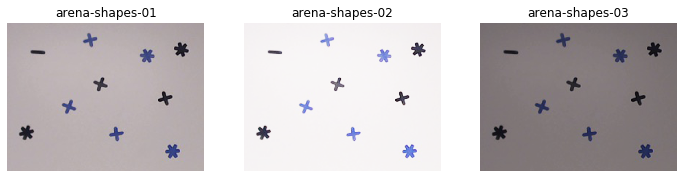

In [280]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

RGB Image:  (480, 640, 3)
Gray scale:  (480, 640)


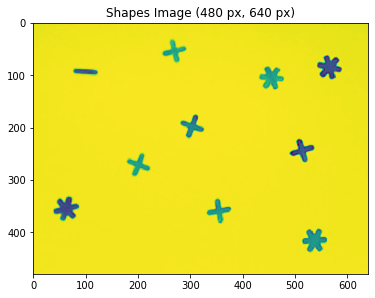

In [281]:
img = skimage.io.imread(filenames[1])
gray_img = skimage.color.rgb2gray(img)
print("RGB Image: ", img.shape)
print("Gray scale: ", gray_img.shape)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(gray_img)
ax.set_title('Shapes Image ({} px, {} px)'.format(img.shape[0], img.shape[1]))
ax.axis('ON')
plt.show()

Here below a histogram in order for us to see the distribution of the color channels in the image

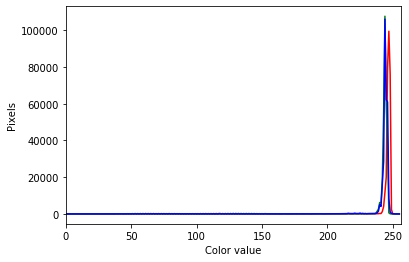

In [282]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img[:, :, channel_id], bins = 256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

**Normalization**: in order to to do further processing steps for these we have to normalize it, map its value from [0 - 255] into [0 - 1]

In [283]:
#We need to do normalization
def normalize(src):
    src = src / 255.0
    return src

In [284]:
img_norm = img / 255.0
print("Max: ", img_norm.max())

Max:  0.9921568627450981


**Thresholding** is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from color or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.

**Process :** 
- We want to leave the pixels belonging to the shapes “on,” while turning the rest of the pixels “off,” by setting their color channel values to zeros. The skimage library has several different methods of thresholding. We will start with the simplest version, which involves an important step of human input. Specifically, in this simple, fixed-level thresholding, we have to provide a threshold value T.
- The process works like this. First, we will load the original image, convert it to grayscale, and blur it with one of the methods from the Blurring episode. Then, we will use the > operator to apply the threshold t, a number in the closed range [0.0, 1.0]. Pixels with color values on one side of t will be turned “on,” while pixels with color values on the other side will be turned “off.” 

- In order to use this function, we have to determine a good value for t. How might we do that? Well, one way is to look at a grayscale histogram of the image.

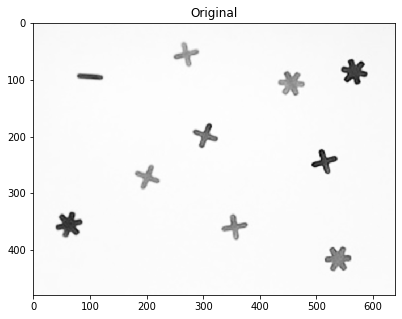

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.imshow(gray_img, cmap='gray')
ax.set_title('Original')
ax.axis('on')
plt.show()

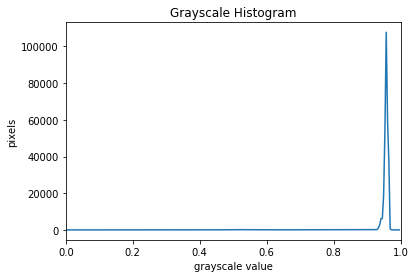

In [286]:
# create the histogram
histogram, bin_edges = np.histogram(gray_img, bins = 256, range=(0, 1))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

<font>**Comment:** </font>

We see that most pixels in gray-scale are approximately equal to value 1, due to that the majority of pixels are white (Background of the image is white)

In [580]:
from skimage.morphology import closing, square
from skimage.segmentation import clear_border

# In this case, we will be using Gausiann bluring method alread built-in SkImage
# Blurring Sigma : a tuple defining the sigma to use in y- and x-direction, (sigma, sigma)
k = 2

def preprocessing(img, k = 2, t = 0.8):
    """
    img: source image
    k : blurring Sigma a tuple defining the sigma to use in y- and x-direction, (sigma, sigma)
    t : thresholding value which should be a float in the closed range [0.0, 1.0].
    return and RGB image (N * D*  3) with less noise and m
    """
    # blur and grayscale before thresholding
    gray = skimage.color.rgb2gray(img)
    blur = skimage.filters.gaussian(gray, sigma = k)
    
    t = skimage.filters.threshold_otsu(blur)
    #The fixed-level thresholding is performed using numpy comparison operators.
    
    #Apply closing : The morphological closing on an image is defined as a dilation followed by an erosion. 
    #Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. 
    #This tends to “close” up (dark) gaps between (bright) features.
    mask = closing(blur > t, square(5))
    #mask = blur < t
    
    # remove artifacts connected to image border
    cleared = clear_border(mask)
    
    # use the mask to select the "interesting" part of the image
    sel = np.zeros_like(img)
    sel[cleared] = img[cleared]
    return cleared, sel

- We apply Gaussian filter in order to blurr the image, such that the borders and edges will be more sharper.
- The function skimage.filters.threshold_otsu() uses Otsu’s method to automatically determine the threshold value based on its inputs grayscale histogram and returns it.

- We applied closing in preprocessing function to denoise the image, by removing "pepper and salt" noise.

In [581]:
new_mask, new_img = preprocessing(img)

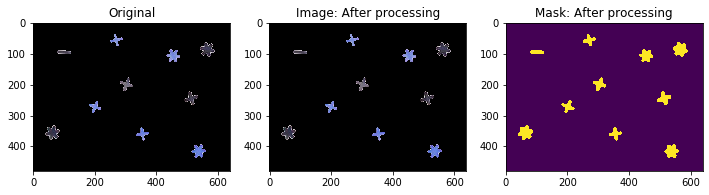

In [582]:
fig, ax = plt.subplots(1, 3, figsize=(12, 10))

ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('on')

ax[1].imshow(new_img)
ax[1].set_title('Image: After processing')
ax[1].axis('on')

ax[2].imshow(new_mask)
ax[2].set_title('Mask: After processing')
ax[2].axis('on')

plt.show()

In [290]:
def detect_labels(src):
    """
    src: image after performing noise cancelling and masking
    returns -> * label_image: image containing only interesting objects
               * b : number of interesting objects in the image
    """
    # Perform CCA on the mask
    gray = skimage.color.rgb2gray(src)
    gray[gray > 100] = 255
    label_image, b = skimage.measure.label(gray, connectivity=2, return_num=True)
    return label_image, b

In [291]:
labels, count = detect_labels(img)
labels_after, count_after = detect_labels(new_mask)

In [293]:
print("\t--- After processing ----")
print("\tShape: ", labels_after.shape)
print("\tNumber of objects: ", count_after)

	--- After processing ----
	Shape:  (480, 640)
	Number of objects:  10


-----------------------------------------------------------------------------------------------
- **Problem:**  it seems that our images differ in contrast and brightness, so we need to create a routine in order to to get a more robust methods of processing although the input images have very low brightness.

**Enhancing contrast and brightness of image:**

Brightness and contrast are very well known image adjustments but let’s mention them nevertheless :

– Brightness refers to the absolute value of colors (tones) lightness/darkness.
Increasing brightness of an image will light out all colors so the original light ones will become up to white.
Reversely, decreasing brightness will darken all colors so the original shaded ones will become up to black.

– Contrast is the distinction between lighter and darker areas of an image, and it rerefers to making more obvious the objects or details within an image.
Increasing contrast on an image will increase the difference between light and dark areas so light areas will become lighter and dark areas will become darker.
Reversely, decreasing the contrast will make lighter and darker areas stay approximately the same but the overall image becomes more “flat” and starts looking as if it were “washed out”.

In [294]:
# Image we will use in further tasks
#loading image
img1 = skimage.io.imread(filenames[0])
img2 = skimage.io.imread(filenames[1])
img3 = skimage.io.imread(filenames[2])

- Gamma changes the difference between dark and light areas. Decreasing Gamma makes dark areas lighter and light areas darker. Increasing Gamma makes dark areas darker and light areas lighter

In [295]:
#Built-in functions in Skimage library to increase brightness in images
# Gamma
gamma_corrected1 = exposure.adjust_gamma(img, 0.3)
gamma_corrected2 = exposure.adjust_gamma(img, 2)
gamma_corrected3 = exposure.adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected1 = exposure.adjust_log(img, 1)
logarithmic_corrected2 = exposure.adjust_log(img, 1)
logarithmic_corrected3 = exposure.adjust_log(img, 1)

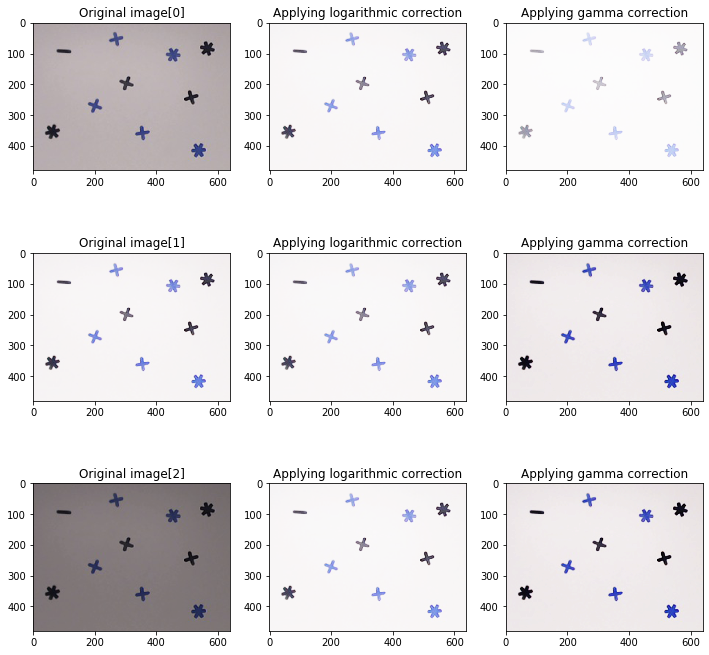

In [296]:
imgs = [img1, img2, img3]
log_imgs = [logarithmic_corrected1, logarithmic_corrected2, logarithmic_corrected3]
gamma_ims = [gamma_corrected1, gamma_corrected2, gamma_corrected3]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    axes[i][0].imshow(imgs[i])
    axes[i][0].set_title("Original image[%d]"%i)
    axes[i][1].imshow(log_imgs[i])
    axes[i][1].set_title("Applying logarithmic correction")
    axes[i][2].imshow(gamma_ims[i])
    axes[i][2].set_title("Applying gamma correction")
plt.show()

-----------------------------------------------------------------------------------------------

- **Adaptive histogram equalization (AHE)** is a contrast enhancement technique which overcomes the limitations of standard histogram equalization. Unlike ordinary histogram equalization the adaptive method redistributes the lightness values of the image based on several histograms, each corresponding to a distinct section of the image. It is therefore useful for improving the local contrast and enhancing the definitions of edges in each region of an image. However, AHE has a tendency to overamplify noise in relatively homogeneous regions of an image. Contrast limited adaptive histogram equalization (CLAHE) prevents this by limiting the amplification.

In [297]:
# Using : Contrast Limited Adaptive Histogram Equalization
def increase_brightness(src):
    hist, bins = np.histogram(src.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    imgg = cdf[img]
    return imgg

In [298]:
bright_img1 = increase_brightness(img1)
bright_img2 = increase_brightness(img2)
bright_img3 = increase_brightness(img3)

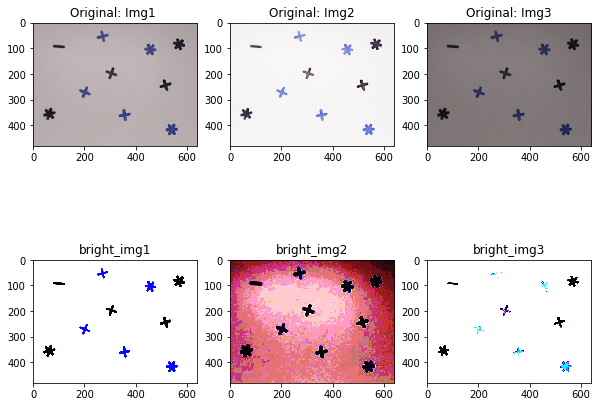

In [299]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes[0][0].imshow(img1)
axes[0][0].set_title("Original: Img1 ")

axes[0][1].imshow(img2)
axes[0][1].set_title("Original: Img2")

axes[0][2].imshow(img3)
axes[0][2].set_title("Original: Img3")

axes[1][0].imshow(bright_img1)
axes[1][0].set_title("bright_img1")

axes[1][1].imshow(bright_img2)
axes[1][1].set_title("bright_img2")

axes[1][2].imshow(bright_img3)
axes[1][2].set_title("bright_img3")

plt.show()

In [300]:
# Brightness and contrast adjustments: new_img = src * alpha + beta
# The parameters α>0 and β are often called the gain and bias parameters; 
# sometimes these parameters are said to control contrast and brightness respectively.

def enhance_contrast(src, alpha = 1.0, beta = 0):
    """
    src: input image
    Parameters α>0 and β are often called the gain and bias parameters; 
    output : img with same shape of the input output = alpha * src + beta
    """
    new_img = np.zeros(src.shape, src.dtype)
    #print(new_img.shape)
    for y in range(src.shape[0]):
        for x in range(src.shape[1]):
            for c in range(src.shape[2]):
                new_img[y, x, c] = np.clip(alpha * img[y, x, c] + beta, 0, 255)
    return new_img

In [301]:
output1 = enhance_contrast(img1)
output2 = enhance_contrast(img2)
output3 = enhance_contrast(img3)

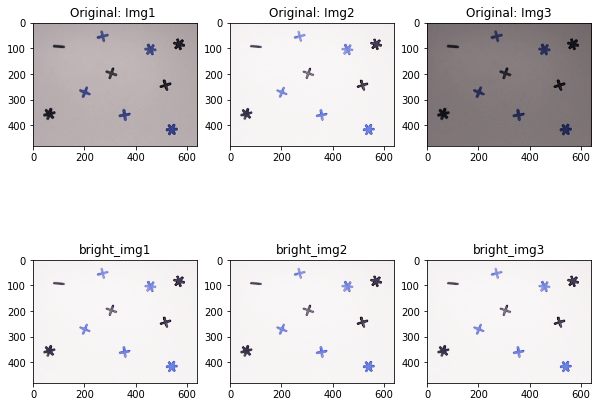

In [302]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes[0][0].imshow(img1)
axes[0][0].set_title("Original: Img1 ")

axes[0][1].imshow(img2)
axes[0][1].set_title("Original: Img2")

axes[0][2].imshow(img3)
axes[0][2].set_title("Original: Img3")

axes[1][0].imshow(output1)
axes[1][0].set_title("bright_img1")

axes[1][1].imshow(output2)
axes[1][1].set_title("bright_img2")

axes[1][2].imshow(output3)
axes[1][2].set_title("bright_img3")

plt.show()

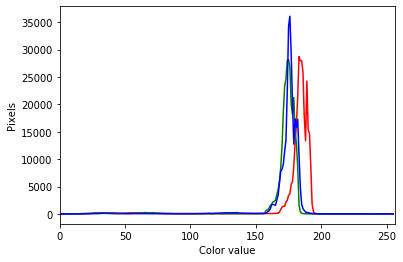

In [303]:
#image 1 before increasing brightness

# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img1[:, :, channel_id], bins = 256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

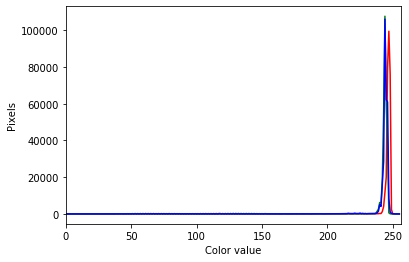

In [304]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        output1[:, :, channel_id], bins = 256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

**Comment:** 

- We can see clearly that the methods used above has different results, as seen the most efficient one for our images is "enhance_contrast()" because it does not alter the shape of images like the others ones as it is demonstrated in the "image 3". It is very slow because we have to go through each pixel in the image but it seems that's it is very efficient.

In [305]:
#After increasing brightness:
mask, img = preprocessing(output1)
labels, count = detect_labels(mask)

In [306]:
print("\tAfter increasing brightness: ")
print("\t Count: ", count)
print("\t labels shape: ", labels.shape)

	After increasing brightness: 
	 Count:  10
	 labels shape:  (480, 640)


In [307]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

image_label_overlay = label2rgb(labels)

Here below, we try to see the labels detected in the previous cells if they are the right object we are looking for

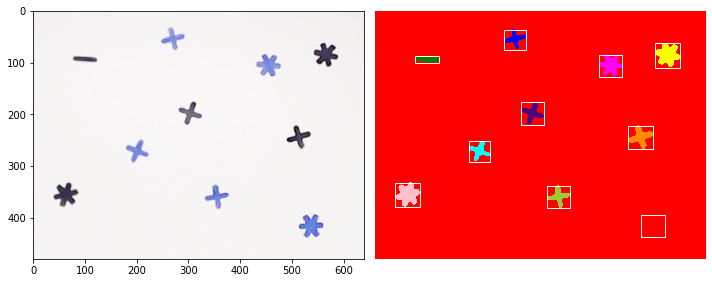

In [309]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(output1)
ax[1].imshow(image_label_overlay)

for region in regionprops(labels):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='white', linewidth=1)
        ax[1].add_patch(rect)

ax[1].set_axis_off()
plt.tight_layout()
plt.show()

In [310]:
shapes = []
for region in regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    shapes.append([minr, minc, maxr, maxc])

print("Shapes properties: [minx, miny, maxx, maxy] \n", shapes)
print("Count Objects: ", len(shapes))

Shapes properties: [minx, miny, maxx, maxy] 
 [[36, 249, 75, 292], [63, 542, 110, 590], [85, 433, 128, 478], [88, 77, 101, 124], [176, 282, 221, 326], [222, 490, 267, 537], [251, 181, 292, 223], [332, 39, 379, 88], [338, 333, 382, 378], [394, 514, 438, 561]]
Count Objects:  10


-----------------------------------------------------------------------------------------------------------------
**Calculating the number of shapes in each color:**

- Well, in order to actually label and tag regions of an image as containing a certain color, we’ll be computing the Euclidean distance between our dataset of known colors and the averages of a particular image region.
- And unlike HSV and RGB color spaces, the Euclidean distance between L*a*b* colors has actual perceptual meaning

The known color that minimizes the Euclidean distance will be chosen as the color identification.

In [313]:
# Defining lower, higher range of each color from HSV Color space
dic = {"lower_blue_white" : np.array([0,10,0]),
        "upper_blue_white" : np.array([20,255,255]),
        "lower_blue" : np.array([0,30,0]),
        "upper_blue" : np.array([20,255,255]),
        "lower_black": np.array([0,0,0]),
        "upper_black": np.array([180,255,30]),
        "lower_green"  : np.array([20,10,0]),
        "upper_green"  : np.array([80,255,255]),
        "lower_yellow" : np.array([80,30,0]),
        "upper_yellow" : np.array([100,255,255]),
        "lower_orange" : np.array([100,182,0]),
        "upper_orange" : np.array([110,255,255]),
        "lower_red" : np.array([110,150,0]),
        "upper_red" : np.array([120,255,255]),
        "lower_pink" : np.array([125,100,0]),
        "upper_pink" : np.array([250,255,255])}

In [314]:
def hsv_detection(image, lower_color, upper_color):  
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv, lower_color, upper_color)
    res = cv2.bitwise_and(image, image, mask = mask1)
    return res

- We will create a mask for each color in dic for the input image.

In [591]:
def apply_color_extraction(src, color):    
    #enhanced_img = enhance_contrast(src, alpha = 1.0, beta = 0)
    #image_new = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2HSV)
    lower = "lower_" + str(color)
    upper = "upper_" + str(color)
    #print(lower)
    extracted = hsv_detection(src, dic[lower], dic[upper])
    return extracted

In [592]:
image_new = cv2.cvtColor(output1, cv2.COLOR_BGR2HSV)

blue = hsv_detection(image_new, dic["lower_blue"], dic["upper_blue"])
blue_white= hsv_detection(image_new, dic["lower_blue_white"], dic["upper_blue_white"])
yellow = hsv_detection(image_new, dic["lower_yellow"], dic["upper_yellow"])
green = hsv_detection(image_new, dic["lower_green"], dic["upper_green"])
orange = hsv_detection(image_new, dic["lower_orange"], dic["upper_orange"])
red = hsv_detection(image_new, dic["lower_red"], dic["upper_red"])
pink = hsv_detection(image_new, dic["lower_pink"], dic["upper_pink"])

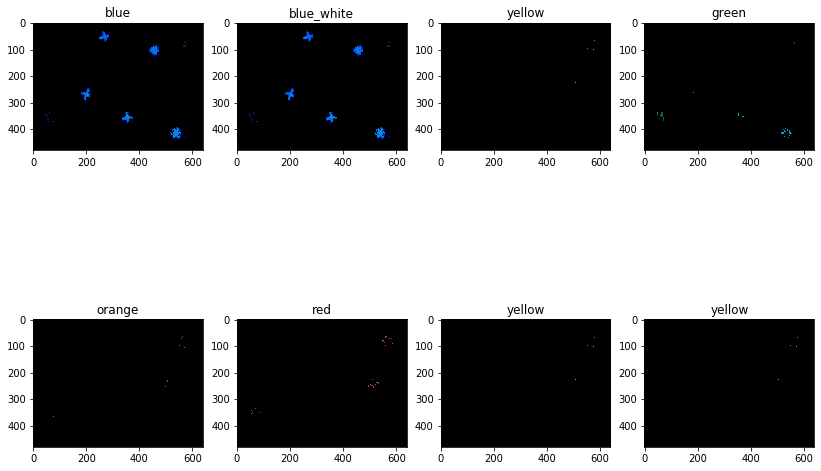

In [593]:
# Threshold the HSV image to get only blue colors
fig, ax = plt.subplots(2, 4, figsize = (14, 10))
ax[0,0].imshow(blue)
ax[0,0].set_title("blue")
ax[0,1].imshow(blue_white)
ax[0,1].set_title("blue_white")
ax[0,2].imshow(yellow)
ax[0,2].set_title("yellow")
ax[0,3].imshow(green)
ax[0,3].set_title("green")

ax[1,0].imshow(orange)
ax[1,0].set_title("orange")
ax[1,1].imshow(red)
ax[1,1].set_title("red")
ax[1,2].imshow(yellow)
ax[1,2].set_title("yellow")
ax[1,3].imshow(yellow)
ax[1,3].set_title("yellow")
plt.show()

**Comment**: We see in the previous images that although we did apply preprocessing functions, but we do still has some noise like in "Red", "Orange", and "Green" images which could be counted afterward as objects therefore, we need to apply some functions in order to remove noise and small objects which we are not interested in.


- <font color=blue>**_Erosion_**</font>: The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white). So what does it do? The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).
- <font color=blue>**_Dilation_**</font>: it increases the white region in the image or size of foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation. Because, erosion removes white noises, but it also shrinks our object. So we dilate it. Since noise is gone, they won’t come back, but our object area increases
- <font color=blue>**_Opening_**</font>: Opening is just another name of erosion followed by dilation. It is useful in removing noise.

In [605]:
def extract_objects(src):
    """
    Function to exctrat objects from src image and apply opening, dilation and erosion to remove noise
    return an clean eroded image
    """
    gray_im = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    gray_corrected = exposure.adjust_gamma(gray_im, 0.3)
    
    thresh = cv2.adaptiveThreshold(gray_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 19)
    thresh = cv2.bitwise_not(thresh)
    
    # Dilatation and erosion
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    img_dilation = cv2.dilate(opening, kernel, iterations=1)
    img_erode = cv2.erode(img_dilation, kernel, iterations=1)
    
    # clean all noise after dilatation and erosion
    img_erode = cv2.medianBlur(img_erode, 5)
    return img_erode

In [606]:
def count_objects(src):    
    """
    Function to count the interesting objects in the src image
    return - count: Number of objects in src image
           - labels: labels of the detected objects
           - labeled_img : an output image with only detected labels in it
    """
    count, labels = cv2.connectedComponents(src)
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    count -= 1
    return count, labels, labeled_img

In [627]:
image_new = cv2.cvtColor(output1, cv2.COLOR_BGR2HSV)
extracted_img = apply_color_extraction(image_new, "blue")

Text(0.5, 1.0, 'extracted image using HSV Color space')

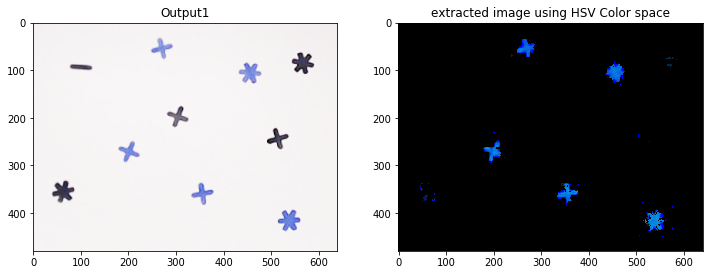

In [628]:
fig, ax = plt.subplots(1, 2, figsize = (12, 10))
ax[0].imshow(output1)
ax[0].set_title("Output1")
ax[1].imshow(extracted_img, cmap="gray")
ax[1].set_title("extracted image using HSV Color space")

In [609]:
#masked, denoised_imggg = preprocessing(extracted_img)
denoised_img = extract_objects(extracted_img)

Text(0.5, 1.0, 'Denoised image')

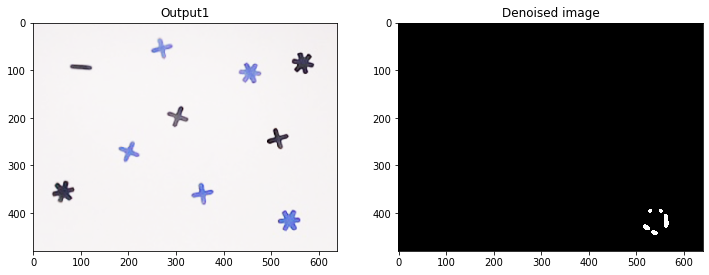

In [610]:
fig, ax = plt.subplots(1, 2, figsize = (12, 10))
ax[0].imshow(output1)
ax[0].set_title("Output1")
ax[1].imshow(denoised_img, cmap="gray", vmin=0, vmax=255)
ax[1].set_title("Denoised image")

**Comment:**

- As illustrated in the 2nd figure above, when applying Closing, and Erosion it will alters the the shape of the object. Therefore, we should take into consideration this when calculating the area of shapes.
- Also, we can see that converting from RGB color space to HSV it effects the image.

In [527]:
nbr, lab, lab_img = count_objects(denoised_img)

In [528]:
print("\t Objects counted for blue color is : ", nbr)

	 Objects counted for blue color is :  5


In [529]:
# Applying the previous methods to each color in our dictionary, and calculate number of objects
colors = ["blue", "green", "yellow", "orange", "blue_white", "red"]
for color in colors:
    src = apply_color_extraction(image_new, color)
    denoised_img = extract_objects(src)
    counter, lab, lab_img = count_objects(denoised_img)
    print("\t Objects counted for ", color, " color is : ", counter)

	 Objects counted for  blue  color is :  5
	 Objects counted for  green  color is :  0
	 Objects counted for  yellow  color is :  0
	 Objects counted for  orange  color is :  0


/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


	 Objects counted for  blue_white  color is :  5
	 Objects counted for  red  color is :  0


### 2.3 Total area (in pixels) of each color

In [630]:
def calculate_area(labels):
    areas = []
    area = 0
    for region in regionprops(labels):
        # region.filled_area : umber of pixels of the region will all the holes filled in. 
        # Describes the area of the filled_image.
        area += region.filled_area
        areas.append(region.filled_area)
    return areas, area

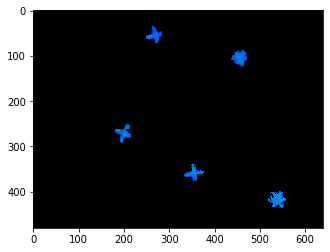

In [576]:
# Getting labels from extracted_img (Bleu in this case)
masked, new_imged = preprocessing(extracted_img)
plt.imshow(new_imged)

**Comment:**

We can see clearly that the shapes has been altered due to morphological operations  done in preprocessing method.

In [577]:
labels, nbrof = detect_labels(masked)

In [578]:
areas, total = calculate_area(labels)

In [579]:
print("\t---------------- For Blue color ----------------")
print("\tNumbers of labels:", nbrof)
print("\tArea of each object: ", areas)
print("\tTotal area:", total)

	---------------- For Blue color ----------------
	Numbers of labels: 5
	Area of each object:  [640, 879, 703, 733, 1061]
	Total area: 4016


In [634]:
# Applying the previous methods to each color in our dictionary, and calculate number of objects
colors = ["blue", "green", "yellow", "orange", "blue_white", "red"]
for color in colors:
    src = apply_color_extraction(image_new, color)
    masked, new_imged = preprocessing(src)
    
    denoised_img = extract_objects(src)
    counter, lab, lab_img = count_objects(denoised_img)
    areas, total = calculate_area(lab)
    print("\t---------------- For %s color ----------------" %color)
    print("\tNumbers of labels:", counter)
    print("\tArea of each object: ", areas)
    print("\tTotal area:", total)

	---------------- For blue color ----------------
	Numbers of labels: 5
	Area of each object:  [52, 60, 252, 125, 102]
	Total area: 591
	---------------- For green color ----------------
	Numbers of labels: 0
	Area of each object:  []
	Total area: 0


/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


	---------------- For yellow color ----------------
	Numbers of labels: 0
	Area of each object:  []
	Total area: 0
	---------------- For orange color ----------------
	Numbers of labels: 0
	Area of each object:  []
	Total area: 0
	---------------- For blue_white color ----------------
	Numbers of labels: 5
	Area of each object:  [52, 60, 252, 125, 102]
	Total area: 591
	---------------- For red color ----------------
	Numbers of labels: 0
	Area of each object:  []
	Total area: 0


### References:
- https://en.wikipedia.org/wiki/Histogram_equalization
- https://www.orpalis.com/blog/color-adjustments-brightness-contrast-and-gamma-2/
- https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
- https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
- https://www.learnopencv.com/invisibility-cloak-using-color-detection-and-segmentation-with-opencv/
- https://towardsdatascience.com/point-operations-in-image-processing-with-skimage-python-5dfeb523ed5c
- https://scikit-image.org/docs/stable/user_guide.html
